In [1]:
%pylab inline
from tqdm import tqdm
import numpy as np
from flowpm.kernels import fftk, laplace_kernel,longrange_kernel,gradient_kernel
from flowpm.utils import c2r3d, r2c3d, cic_paint, cic_readout

Populating the interactive namespace from numpy and matplotlib


In [2]:
snapshots = np.array([
 0.14285714254594556,
 0.16666666542893738,
 0.1999999986832461,
 0.22222222150378537,
 0.24999999806336917,
 0.2622410627683301,
 0.27508150213837845,
 0.2885506615021642,
 0.3026793308840415,
 0.3174997972262324,
 0.3330459395932943,
 0.3493532841474449,
 0.36645910890451366,
 0.38440250769880274,
 0.4032244880783829,
 0.42296807642809625,
 0.4436783909454936,
 0.46540277468080926,
 0.4881908767722827,
 0.5120947767731064,
 0.5371691181575536,
 0.5634712010003641,
 0.5910611509374005,
 0.6200020223344457,
 0.6503599561823248,
 0.682204349649582,
 0.7156079737852235,
 0.7506471880986196,
 0.7874020715837913,
 0.8259566232460903,
 0.8663989774339641,
 0.9088215533213413,
 0.9533213274239392,
 0.9999999999999998])

In [3]:
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import tensorflow_probability as tfp
from flowpm.tfpm import force, kick, drift,make_ode_fn
from flowpm.cosmology import Planck15

In [4]:
nc=128
box_size=200.


In [5]:
cosmology = flowpm.cosmology.Planck15(Omega_c= 0.2 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.7)
initial_conditions = flowpm.linear_field(
    [nc, nc, nc],
    [box_size, box_size, box_size],
    lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),
    batch_size=1)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, snapshots[0])


2022-03-29 07:05:19.125579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-29 07:05:20.384064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38428 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2022-03-29 07:05:20.385677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38428 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-03-29 07:05:20.387147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 

In [6]:

initial_state = initial_state[0:2]
res= tfp.math.ode.DormandPrince().solve(flowpm.make_ode_fn([nc,nc,nc]), snapshots[0], initial_state, solution_times=snapshots, constants={'Omega_c':0.2 - 0.049, 'sigma8':0.7})



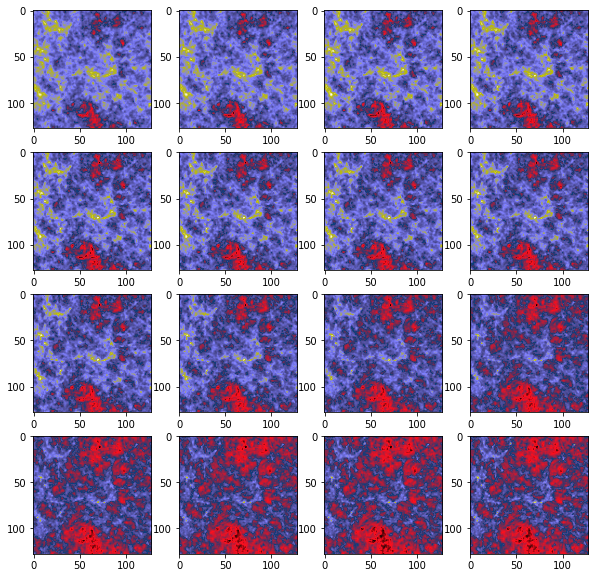

In [7]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(flowpm.cic_paint(tf.zeros_like(initial_conditions), res.states[i,0])[0].numpy().sum(axis=0), cmap='gist_stern')


In [8]:
 k, pk_i = flowpm.power_spectrum(
      flowpm.cic_paint(tf.zeros_like(initial_conditions), res.states[-1,0]),
      boxsize=np.array([box_size, box_size, box_size]) ,
      kmin=np.pi / box_size,
      dk=2 * np.pi / box_size)

In [9]:
import jax_cosmo as jc
cosmo = jc.Planck15(Omega_c= 0.2 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.7)

/global/homes/d/dlan/.local/perlmutter/tensorflow2.6.0/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6623: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


Text(0, 0.5, '$P(k)$')

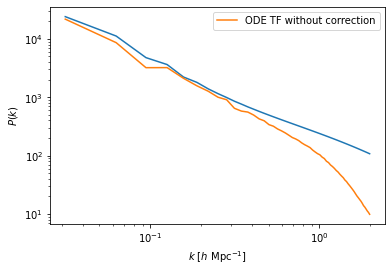

In [10]:
loglog(k, jc.power.nonlinear_matter_power(cosmo, k))
loglog(k, pk_i[0], label='ODE TF without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

#### Define NeuralSplineFourierFilter

In [11]:
import jax
import jax.numpy as jnp
import haiku as hk

def _deBoorVectorized(x, t, c, p):
    """
    Evaluates S(x).
    Args
    ----
    x: position
    t: array of knot positions, needs to be padded as described above
    c: array of control points
    p: degree of B-spline
    """
    k = jnp.digitize(x, t) -1
    
    d = [c[j + k - p] for j in range(0, p+1)]
    for r in range(1, p+1):
        for j in range(p, r-1, -1):
            alpha = (x - t[j+k-p]) / (t[j+1+k-r] - t[j+k-p])
            d[j] = (1.0 - alpha) * d[j-1] + alpha * d[j]
    return d[p]


class NeuralSplineFourierFilter(hk.Module):
  """A rotationally invariant filter parameterized by 
  a b-spline with parameters specified by a small NN."""

  def __init__(self, n_knots=8, latent_size=16, name=None):
    """
    n_knots: number of control points for the spline  
    """
    super().__init__(name=name)
    self.n_knots = n_knots
    self.latent_size = latent_size

  def __call__(self, x, a):
    """ 
    x: array, scale, normalized to fftfreq default
    a: scalar, scale factor
    """
    print("x:",x)
    print("a:",a)
    net = jnp.sin(hk.Linear(self.latent_size)(jnp.atleast_1d(a)))
    net = jnp.sin(hk.Linear(self.latent_size)(net))

    w = hk.Linear(self.n_knots+1)(net) 
    k = hk.Linear(self.n_knots-1)(net)
    
    # make sure the knots sum to 1 and are in the interval 0,1
    k = jnp.concatenate([jnp.zeros((1,)),
                        jnp.cumsum(jax.nn.softmax(k))])

    w = jnp.concatenate([jnp.zeros((1,)),
                         w])

    # Augment with repeating points
    ak = jnp.concatenate([jnp.zeros((3,)), k, jnp.ones((3,))])

    return _deBoorVectorized(jnp.clip(x/jnp.sqrt(3), 0, 1-1e-4), ak, w, 3)


## Convert to TensorFlow

In [12]:
import pickle
from jax.experimental import jax2tf
import sonnet as snt
import tree

In [13]:
def f(x,a):
  net = NeuralSplineFourierFilter(n_knots=16, latent_size=32)(x,a)
  return net

f = hk.without_apply_rng(hk.transform(f))

params = pickle.load( open( "camels_25_64_pkloss.params", "rb" ) )


def create_variable(path, value):
  name = '/'.join(map(str, path)).replace('~', '_')
  return tf.Variable(value, name=name)

class JaxModule(snt.Module):
  def __init__(self, params, apply_fn, name=None):
    super().__init__(name=name)
    self._params = tree.map_structure_with_path(create_variable, params)
    self._apply = jax2tf.convert(lambda p, x, a : apply_fn(p, x, a ))
    self._apply = tf.autograph.experimental.do_not_convert(self._apply)

  def __call__(self, inputs1, inputs2):
    return self._apply(self._params, inputs1, inputs2)


In [14]:
net = JaxModule(params, f.apply)


#### try to apply the NN

In [16]:
kvec = fftk([nc,nc,nc])
kk = tf.math.sqrt(sum((ki/pi)**2 for ki in kvec)) 

/tmp/ipykernel_129030/726485428.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = tf.math.sqrt(sum((ki/pi)**2 for ki in kvec))


In [ ]:
net(kk, tf.convert_to_tensor(jnp.atleast_1d(snapshots[0])))

### Define the ode function

In [ ]:
def neural_nbody_ode(state, a, Omega_c, sigma8, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    kvec = fftk([nc,nc,nc])
    cosmo = Planck15(Omega_c=Omega_c, sigma8=sigma8)
    delta = flowpm.cic_paint(tf.zeros_like(initial_conditions), pos)
    
    delta_k = tf.signal.rfft3d(delta)
    
    # Computes gravitational potential
    lap = tf.cast(laplace_kernel(kvec), tf.complex64)
    fknlrange = longrange_kernel(kvec, r_split=0)
    kweight = lap * fknlrange
    pot_k = tf.multiply(delta_k, kweight)
    
    # Apply a correction filter
    kk = tf.math.sqrt(sum((ki/pi)**2 for ki in kvec))
    net = JaxModule(params, f.apply)

    pot_k = pot_k *(1. + net(kk, jnp.atleast_1d(a)))
    
    # Computes gravitational forces
    
    forces = tf.stack([flowpm.cic_readout(c2r3d(tf.multiply(pot_k, gradient_kernel(kvec, i))), pos) 
                      for i in range(3)],axis=-1)
    forces = forces * 1.5 * cosmo.Omega_m

    #Computes the update of position (drift)
    dpos = 1. / (a**3 * flowpm.tfbackground.E(cosmo, a)) * vel
    
    #Computes the update of velocity (kick)
    dvel = 1. / (a**2 * flowpm.tfbackground.E(cosmo, a)) * forces
    
    return dpos, dvel

In [ ]:
res= tfp.math.ode.DormandPrince().solve(neural_nbody_ode, snapshots[0], initial_state, solution_times=snapshots[::2], constants={'Omega_c':0.2 - 0.049, 'sigma8':0.7})
